<a href="https://colab.research.google.com/github/DelphianCalamity/kaggle-exploration/blob/master/kaggle_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
pip install kaggle
pip install wordcloud

kaggle_path="/root/.kaggle"
if [ ! -d ${kaggle_path} ]; then 
  mkdir ${kaggle_path}
fi
kaggle_config=${kaggle_path}"/kaggle.json"
echo '''{"username":"kk3440","key":"017de95c899c3d681c325fb36cfff464"}''' > ${kaggle_config}
# chmod 600 ${kaggle_config}
# kaggle config path -p kaggle_path

Kaggle Python API: https://technowhisp.com/kaggle-api-python-documentation/



In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os

api = KaggleApi()
api.authenticate()

def download_notebooks(search=None, page_size=2, dataset= None, competition=None):
  parent_dir = "/content/notebooks"
  # Signature: 
  # kernels_list(page=1, page_size=20, dataset=None, competition=None,
  #  parent_kernel=None, search=None, mine=False, user=None, language=None,
  #  kernel_type=None, output_type=None, sort_by=None)
  kernel_refs = []
  kernels = api.kernels_list(search=search, page_size=page_size)
  for kernel in kernels:
    kernel_refs.append(kernel.ref)
    log_path = os.path.join(parent_dir, kernel.ref, "log")
    if not os.path.exists(log_path):
      os.makedirs(log_path)
      api.kernels_output(kernel.ref, log_path, force=False, quiet=True)             # Yields the log file

    notebook_path = os.path.join(parent_dir, kernel.ref, "notebook")
    if not os.path.exists(notebook_path):
      os.makedirs(notebook_path)
      api.kernels_pull(kernel.ref, path=notebook_path, metadata=True, quiet=True)   # Yields notebook & metadata

  # The above methods return the actual names of the files that were downloaded
  # May be more useful to use those to return a list of file paths
  # Especially since kernel.ref != filename

  # I pushed the above methods into the ifs so that we don't download the notebooks 
  # in case they are already in the disk. so, now we might not have necesserily 
  # the filenames for every run!!

  return kernel_refs

#### Downloading notebooks related to a search key (eg.  nlp, image, ..) and retrieving info

In [12]:
# api.kernels_list(search='nlp', page_size=2)

def explore_notebooks(explore_func=None, search=None, page_size=5):
  # api.kernels_list(search='nlp', page_size=2)
  notebooks = download_notebooks(search, page_size)
  # print(notebooks)
  explore_func(notebooks)


In [ ]:
# For now assuming notebooks is a list of paths

import json
import re

def explore_import_statements(notebooks):
  module_dict = {}
  regex = "(?m)(?:from[ ]+(\S+)[ ]+)?import[ ]+(\S+)(?:[ ]+as[ ]+\S+)?(?:\n)?"

  for notebook in notebooks:
    print(notebook)
    name, ext = os.path.splitext(notebook)
    kernel_module_dict = {}

    if ext == '.ipynb':
      new_name = name + '.json'
      os.rename(notebook, new_name)
      with open(new_name) as f:
        data = json.load(f)
        print(data)
      
      cells = data['cells']
      for cell in cells:
        if cell['cell_type'] == 'code':
          code = cell['source']
          matches = re.findall(regex, code)

          for match in matches:
            if match[0] == '':
              kernel_module_dict[match[1].split('.')[0]] = 1
            else:
              kernel_module_dict[match[0].split('.')[0]] = 1

    elif ext == '.py':
      with open(notebook) as f:
        filetext = f.read()
      matches = re.findall(regex, filetext)
      for match in matches:
        if match[0] == '':
          kernel_module_dict[match[1].split('.')[0]] = 1
        else:
          kernel_module_dict[match[0].split('.')[0]] = 1
    
    else:
      continue;

    for key in kernel_module_dict.keys():
      if key in module_dict:
        module_dict[key] = module_dict[key] + 1
      else:
        module_dict[key] = 1
  
  return module_dict

mod = explore_notebooks(explore_func=explore_import_statements, search='nlp', page_size=5)

In [90]:
# Explore Import Statements
import json
import re
import pprint
import matplotlib.pyplot as plt
from wordcloud import WordCloud

pp = pprint.PrettyPrinter(indent=4)

def explore_import_statements(notebooks):
  module_dict = {}
  keys = []
  regex = "(?m)(?:from[ ]+(\S+)[ ]+)?import[ ]+(\S+)(?:[ ]+as[ ]+\S+)?(?:\n)?"

  for notebook in notebooks:
    path = os.path.join("notebooks", notebook, "notebook")
    path_files = os.listdir(path)

    kernel_module_dict = {}

    for file in path_files:
      _, ext = os.path.splitext(file)

      if ext in {'.ipynb', '.py'}:
        file = os.path.join(path, file)

        with open(file) as f:
          
          if ext == '.ipynb':
            data = json.load(f)
            cells = data['cells']
            for cell in cells:
              if cell['cell_type'] == 'code':
                code = cell['source']
                matches = re.findall(regex, code)
                for match in matches:
                  if match[0] == '':
                    kernel_module_dict[match[1].split('.')[0]] = 1
                  else:
                    kernel_module_dict[match[0].split('.')[0]] = 1

          elif ext == '.py':
            with open(notebook) as f:
              filetext = f.read()
            matches = re.findall(regex, filetext)
            for match in matches:
              if match[0] == '':
                kernel_module_dict[match[1].split('.')[0]] = 1
              else:
                kernel_module_dict[match[0].split('.')[0]] = 1

          for key in kernel_module_dict.keys():
            keys.append(key)
            if key in module_dict:
              module_dict[key] = module_dict[key] + 1
            else:
              module_dict[key] = 1

  # pp.pprint(module_dict)
  modules = "".join([key+" " for key in keys])
  # print(modules)
  
  wordcloud = WordCloud(max_font_size=40, random_state=1).generate(modules)
  
  plt.figure(figsize=(10,10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()
  

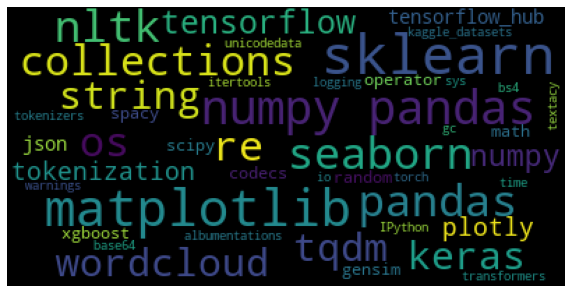

In [92]:
# Natural Language Processing
explore_notebooks(explore_func=explore_import_statements, search='nlp', page_size=20)
